In [1]:
from transformers import pipeline
from PIL import ImageDraw
from PIL import Image
import numpy as np

import skimage

/Users/thivyeshahilathasan/Library/Caches/pypoetry/virtualenvs/cv-tutorial-cap-aU5aeIk7-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Initialize detection pipeline
checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

In [3]:
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

In [4]:
predictions = detector(
    image,
    candidate_labels=["face", "rocket", "nasa badge", "star-spangled banner"]
)

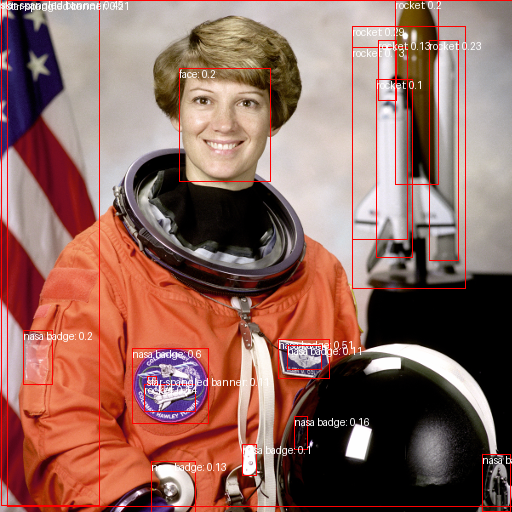

In [5]:
draw = ImageDraw.Draw(image)
for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

display(image)

In [6]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

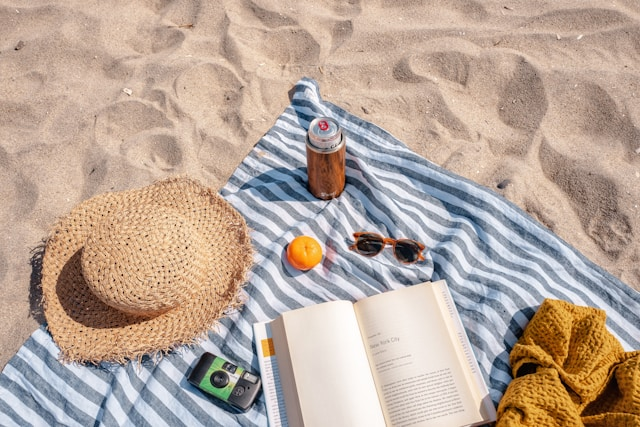

In [7]:
import requests

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)
display(im)

In [8]:
text_queries = ["hat", "book", "sunglasses", "camera"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

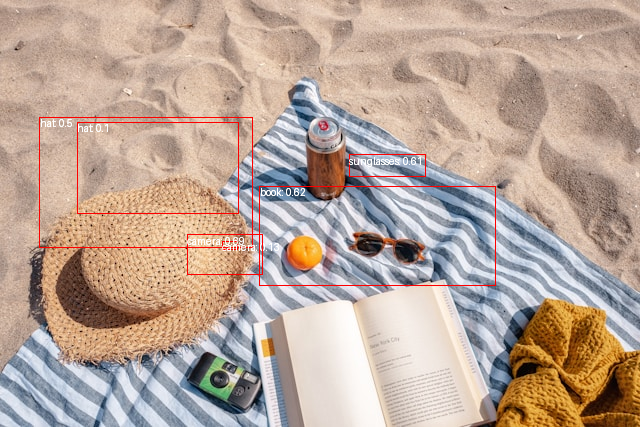

In [10]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im

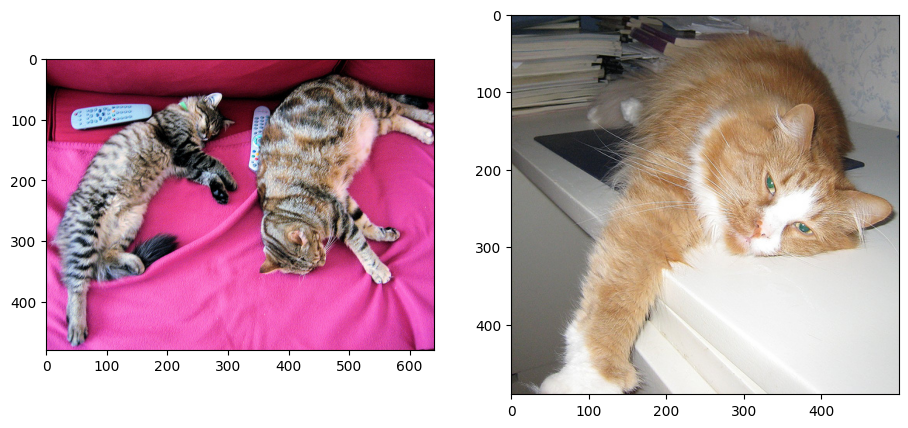

In [25]:
# Import necessary libraries
# %matplotlib inline  # Uncomment this line for compatibility if using Jupyter Notebook.
import cv2
from PIL import Image
import requests
import torch
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Set the figure size
rcParams['figure.figsize'] = 11, 8

# Load the input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Load the query image
query_url = "http://images.cocodataset.org/val2017/000000058111.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display the input image and query image side by side.
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [26]:
# Define the device to use for processing.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Process input and query images using the preprocessor.
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print the input names and shapes.
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 960, 960])
pixel_values: torch.Size([1, 3, 960, 960])


In [27]:
# Perform image-guided object detection using the model.
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

# Print the shapes of the model's outputs.
for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 3600, 1])
image_embeds: shape of torch.Size([1, 60, 60, 768])
query_image_embeds: shape of torch.Size([1, 60, 60, 768])
target_pred_boxes: shape of torch.Size([1, 3600, 4])
query_pred_boxes: shape of torch.Size([1, 3600, 4])
class_embeds: shape of torch.Size([1, 3600, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 3601, 768])
pooler_output: shape of torch.Size([1, 768])


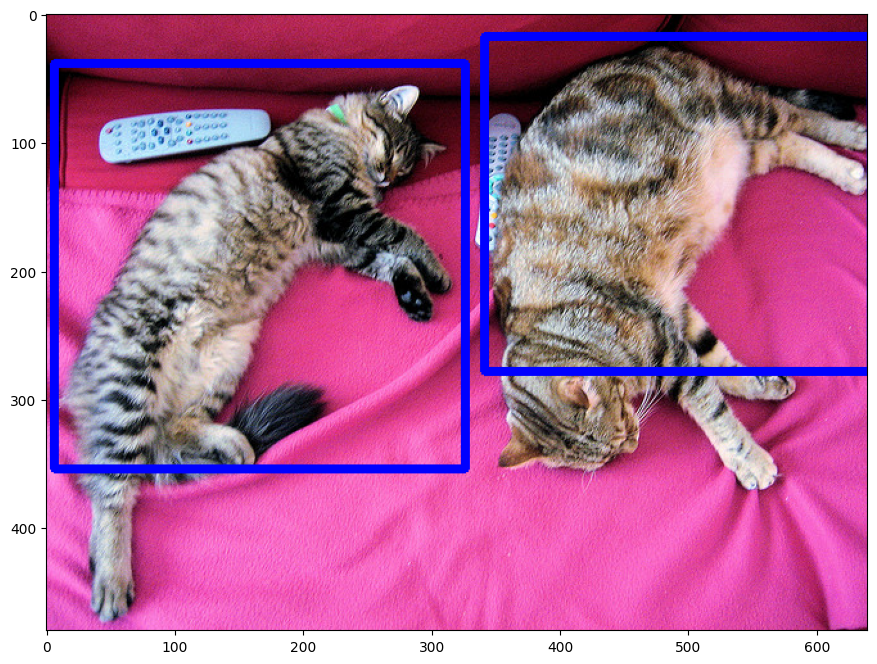

In [28]:
# Visualize the results
import numpy as np
import cv2

# Convert the image to RGB format.
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

# Post-process the detection results.
results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.9, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw bounding boxes on the image.
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255, 0, 0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

# Display the image with predicted bounding boxes.
plt.imshow(img[:, :, ::-1])